# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./azdias.csv', low_memory = False)
customers = pd.read_csv('./customers.csv', low_memory = False)

In [3]:
# Let us first look at the shape and look of the demographics data
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Examine the data types for each column 
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [5]:
# Count the number of nans in each column 
azdias.isnull().sum(axis = 0)

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [6]:
# Count the number of nans in each row 
azdias.isnull().sum(axis = 1)

0         252
1          15
2           5
3           7
4           5
         ... 
891216     11
891217      6
891218      8
891219      4
891220     16
Length: 891221, dtype: int64

## Part 1: Data cleansing and preparation

In [7]:
# Load features table 
features = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', sheet_name = 'Tabelle1', header = 1)
features.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [8]:
# Explore meaning of feature counts in search of ones that are unknown or undetermined
features['Meaning'].value_counts()

unknown                                                        233
average                                                        162
low                                                            154
high                                                           154
very high                                                      142
                                                              ... 
company building                                                 1
mixed building without actually known household                  1
company building w/o known company                               1
mixed building without actually known household or comapny       1
indifferent                                                      1
Name: Meaning, Length: 538, dtype: int64

In [9]:
# Extract rows that contain "unknown" value 
feature_extract = features[features['Meaning'].isin(['unknown', 'unknown / no main age detectable', 'no transaction known','no transactions known'])].drop('Unnamed: 0', axis = 1)
feature_extract.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [10]:
# Create a column with list of missing value for every feature
missing_vals = []
for val in feature_extract['Value']:
    val = str(val)
    list_val = val.split(',')
    missing_vals.append(list_val)
feature_extract['Unknown Value'] = missing_vals
feature_extract['Unknown Value'] = feature_extract['Unknown Value'].map(lambda x : list(map(int, x)))
feature_extract.head()

,Attribute,Description,Value,Meaning,Unknown Value
0,AGER_TYP,best-ager typology,-1,unknown,[-1]
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
11,ALTER_HH,main age within the household,0,unknown / no main age detectable,[0]
33,ANREDE_KZ,gender,"-1, 0",unknown,"[-1, 0]"
40,BALLRAUM,distance to next urban centre,-1,unknown,[-1]


In [11]:
# Define a function that fills in unknown values with nans 
def nan_fill(data, features):
    '''In this function, unknown or undefined entries 
    are filled with NaNs'''
    
    # Create a copy of the original dataframe 
    data_new = data.copy()
    
    # Loop to replace all unknown values with nans
    for row in features['Attribute']:
        if row in data.columns:
            na_rule = features.loc[features['Attribute'] == row, 'Unknown Value'].iloc[0]
            na_idx = data.loc[:, row].isin(na_rule)
            data_new.loc[na_idx, row] = np.nan
        else:
            continue
            
    return data_new

In [12]:
# Test our function 
azdias = nan_fill(azdias, feature_extract)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [13]:
# Determine number of nans per column
azdias_new = azdias.copy()
count_nan = azdias.isnull().sum()/len(azdias)
count_nan

LNR                     0.000000
AGER_TYP                0.760196
AKT_DAT_KL              0.082470
ALTER_HH                0.348137
ALTER_KIND1             0.909048
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.104517
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 366, dtype: float64

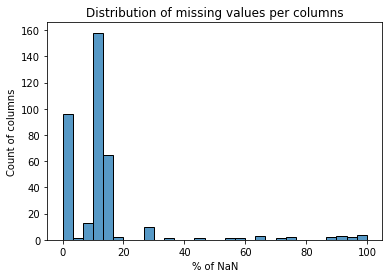

In [14]:
# Create a histogram containing the distribution of missing values per column 
ax = sns.histplot(count_nan.values*100, kde=False, bins = 30)
ax.set_ylabel('Count of columns')
ax.set_xlabel('% of NaN')

plt.title('Distribution of missing values per columns')
plt.show()

In [15]:
# Reviewing the histogram, we can see that there are relatively few columns with over 30% missing data 
dropping = count_nan[count_nan > 0.30].index.tolist()
dropping

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [16]:
# Drop the relevant columns
azdias = azdias.drop(dropping, axis=1)

In [17]:
# Reveal the shape of the df after dropping columns
azdias.shape

(891221, 345)

Through this first pass analysis, we were able to remove 21 columns 

## 1.2 Deeper analysis

In this section, we perform a similar analysis but on the rows as opposed to the columns

In [18]:
# Evaluate missing data per row
missing_row_values = azdias.isnull().sum(axis=1)
missing_row_values

0         248
1           9
2           0
3           4
4           0
         ... 
891216      6
891217      4
891218      2
891219      0
891220     10
Length: 891221, dtype: int64

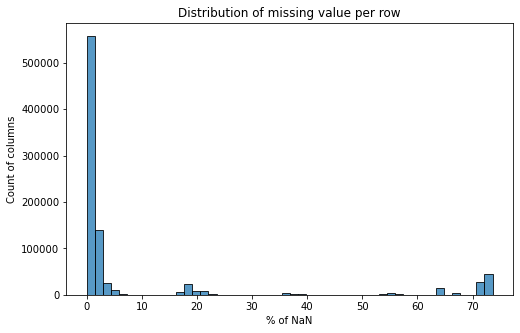

In [19]:
# Create a histogram containing the distribution of missing values per row
fig = plt.figure(figsize=(8, 5))
ax = sns.histplot(missing_row_values.values/azdias.shape[1]*100, kde=False, bins = 50)
ax.set_ylabel('Count of columns')
ax.set_xlabel('% of NaN')

plt.title('Distribution of missing value per row')
plt.show()

In [20]:
# Reveal some descriptive stats from the df 
missing_row_values.describe()

count    891221.000000
mean         33.699268
std          75.541578
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max         254.000000
dtype: float64

In [21]:
# Our analysis revealed that the average number of missing values is 33.69, so we will keep the rows with less than
# 34 missing values
threshold = 34
azdias_low = azdias[missing_row_values < threshold].reset_index(drop=True)
azdias_low

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
3,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
4,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737171,825761,5.0,17.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4.0,2.0,3.0
737172,825771,9.0,16.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6.0,1.0,2.0
737173,825772,1.0,17.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4.0,2.0,2.0
737174,825776,9.0,20.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5.0,1.0,1.0


In [22]:
# Start by creating encoding for the object columns
azdias_low.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
1,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
2,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
3,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
4,8C,8.0,54.0,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
737171,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
737172,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
737173,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
737174,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [23]:
# Create a function to convert multi-encoded variables into dummies
def create_dummies(df, variables_list):
    '''In this function, we create dummies for each of the multi-encoded variables'''
    
    # Run a for loop that iterates over the variables and create dummies for each 
    for variable in variables_list:
        dummies_df = pd.get_dummies(df[variable], prefix=variable)
        df.drop(variable, axis=1, inplace=True)
        df = pd.concat([df, dummies_df], axis=1)
        
    return df

In [24]:
# CAMEO_INTL_2015 needs its own coding due to being a compounded variable
def breakup_CAMEO(x, digit):
    '''In this function, we breakup the CAMEO code by wealth and life stage'''
    
    # For all non-nans extract first and second digits into separate categories
    if not pd.isna(x):
        if digit == 'first':
            return int(str(x)[0])
        elif digit == 'second':
            return int(str(x)[1])
    return x

In [25]:
# From visual inspection, we see that there are variables with multiple encodings
multi_encoding = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                   'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ','SHOPPER_TYP', 'ZABEOTYP', 
                   'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# Also from visual inspection, we can observe that 'PRAEGENDE_JUGENDJAHRE' can be broken into two categories
decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90, 
          np.nan: np.nan, -1: np.nan, 0: np.nan}
avantgarde = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1,
              np.nan: np.nan, -1: np.nan, 0: np.nan}

In [26]:
def clean_data(df):
    '''The main purpose of this function is to perform stepwise cleaning 
    of the AZDIAS and CUSTOMERS dataframes'''
    
    # Create a copy of the original df
    df_c = df.copy()
    
    # From above row and column analysis, remove the following 
    missing_row_values = df_c.isnull().sum(axis=1)
    
    threshold = 34
    df_c = df_c[missing_row_values < threshold].reset_index(drop=True)
    df_c = df_c.drop(dropping, axis=1)
    
    # Drop these two additional columns based on being purely strings 
    df_c = df_c.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1)
    
    # Create an encoding for the column with a simple numerical scheme
    df_c['OST_WEST_KZ'] = df_c['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # Transform variables into dummies using function above
    df_c = create_dummies(df_c, multi_encoding)
    
    # Create a new encoding for variables as defined above 
    df_c['YOUTH'] = df_c['PRAEGENDE_JUGENDJAHRE'].map(decade)
    df_c['AVANTGARDE'] = df_c['PRAEGENDE_JUGENDJAHRE'].map(avantgarde)
    df_c = df_c.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Clean up leftover unknown values
    df_c['WOHNLAGE'] = df_c['WOHNLAGE'].replace(0, np.nan)
    
    # Perform additional cleaning of the CAMEO_INTL_2015 column
    df_c['CAMEO_INTL_2015'] = df_c['CAMEO_INTL_2015'].replace('XX', np.nan)
    df_c['CAMEO_INTL_2015'] = df_c['CAMEO_INTL_2015'].apply(lambda x: float(x))

    df_c['CAMEO_INTL_2015_WEALTH'] = df_c['CAMEO_INTL_2015'].apply(breakup_CAMEO, digit='first')
    df_c['CAMEO_INTL_2015_LIFE_STAGE'] = df_c['CAMEO_INTL_2015'].apply(breakup_CAMEO, digit='second')
    df_c.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    return df_c

In [27]:
# Reveal what the cleaned up dataframe looks like 
azdias_clean = clean_data(azdias_new)
azdias_clean

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,YOUTH,AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,0,0,90.0,0.0,5.0,1.0
1,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,0,0,0,0,90.0,1.0,2.0,4.0
2,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0,0,0,0,0,0,70.0,0.0,1.0,2.0
3,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,0,0,0,0,0,70.0,0.0,4.0,3.0
4,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,50.0,0.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718499,825761,5.0,17.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,...,0,0,0,0,0,0,90.0,0.0,4.0,1.0
718500,825771,9.0,16.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,...,0,0,0,1,0,0,80.0,0.0,5.0,1.0
718501,825772,1.0,17.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,...,0,0,0,0,0,0,90.0,0.0,2.0,4.0
718502,825776,9.0,20.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,...,0,0,0,1,0,0,90.0,0.0,5.0,1.0


In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# Call SimpleImputer and MinMaxScaler from the sklearn library
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler()

In [29]:
# Perform imputation and scaling of cleaned up dataframe
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean), columns=azdias_clean.columns)
azdias_ss = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)

In [30]:
azdias_imputed.describe()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,YOUTH,AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,7.185040e+05,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,...,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000
mean,6.369664e+05,4.342587,13.672707,8.109394,0.038779,0.148993,1.750395,7.376716,0.004082,3.177739,...,0.026825,0.034860,0.030550,0.035816,0.005211,0.000380,73.116474,0.230819,3.271059,2.877740
std,2.579159e+05,3.627003,4.493647,15.001113,0.308007,0.493193,1.167904,13.533561,0.067761,0.995727,...,0.161572,0.183425,0.172094,0.185831,0.071998,0.019489,14.522945,0.418457,1.463584,1.485884
min,1.916530e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,1.000000,1.000000
25%,4.140698e+05,1.000000,12.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,2.000000,1.000000
50%,6.348475e+05,2.000000,13.672707,4.000000,0.000000,0.000000,1.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,4.000000,3.000000
75%,8.617848e+05,9.000000,16.000000,9.000000,0.000000,0.000000,2.000000,9.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,0.000000,5.000000,4.000000
max,1.082872e+06,9.000000,25.000000,536.000000,20.000000,11.000000,38.000000,375.000000,4.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,5.000000,5.000000


In [31]:
azdias_ss.describe()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,YOUTH,AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,...,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000,718504.000000
mean,0.499668,0.417823,0.546908,0.015129,0.001939,0.013545,0.046063,0.019671,0.001021,0.272217,...,0.026825,0.034860,0.030550,0.035816,0.005211,0.000380,0.662329,0.230819,0.567765,0.469435
std,0.289397,0.453375,0.179746,0.027987,0.015400,0.044836,0.030734,0.036089,0.016940,0.124466,...,0.161572,0.183425,0.172094,0.185831,0.071998,0.019489,0.290459,0.418457,0.365896,0.371471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249565,0.000000,0.480000,0.003731,0.000000,0.000000,0.026316,0.002667,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.250000,0.000000
50%,0.497290,0.125000,0.546908,0.007463,0.000000,0.000000,0.026316,0.010667,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.750000,0.500000
75%,0.751927,1.000000,0.640000,0.016791,0.000000,0.000000,0.052632,0.024000,0.000000,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can observe that the final dataframe is imputed using the mean and scaled to be readily used in computation 

## Part 2: Segmentation Analysis and Data Comparison 

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [32]:
# Call PCA method
pca = PCA()
pca_fit = pca.fit(azdias_ss)

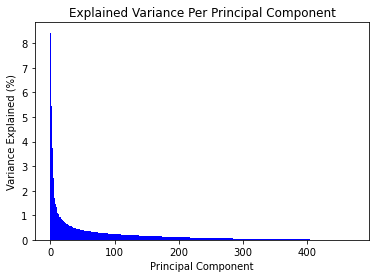

In [33]:
# Create a plot that details variance explained by each component
num_components=len(pca.explained_variance_ratio_)
inds = np.arange(num_components)
vals = pca.explained_variance_ratio_*100

plt.bar(inds, vals, width = 1.8, color='b');
 
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance Per Principal Component');

In [34]:
def scree_plot(pca): # Function from PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of the PCA method from sklearn
            
    RETURN: None
    '''
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(num_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

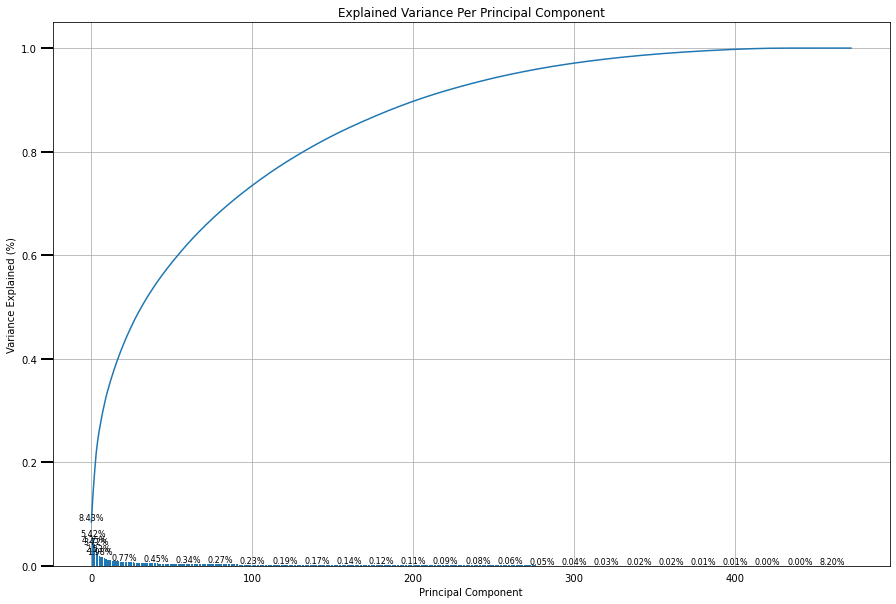

In [35]:
scree_plot(pca)

From this analysis, we conclude that about 150 components are sufficient to explain most of the variance

## Dimensionality reduction

In [36]:
# Select 150 components to retain >80% of the variance 
pca = PCA(n_components=150)
azdias_pca = pca.fit_transform(azdias_ss)

In [37]:
azdias_ss

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,YOUTH,AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,0.806274,1.0,0.840000,0.020522,0.0,0.000000,0.052632,0.032000,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.00
1,0.806280,1.0,0.680000,0.018657,0.0,0.000000,0.026316,0.018667,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.25,0.75
2,0.806281,0.0,0.520000,0.001866,0.0,0.000000,0.000000,0.005333,0.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.00,0.25
3,0.806298,0.0,0.560000,0.005597,0.0,0.000000,0.105263,0.008000,0.0,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.75,0.50
4,0.806301,0.0,0.400000,0.009328,0.0,0.000000,0.026316,0.005333,0.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718499,0.711506,0.5,0.680000,0.027985,0.0,0.000000,0.026316,0.029333,0.0,0.272217,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.00
718500,0.711518,1.0,0.640000,0.020522,0.0,0.000000,0.026316,0.029333,0.0,0.375000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.8,0.0,1.00,0.00
718501,0.711519,0.0,0.680000,0.005597,0.0,0.000000,0.000000,0.008000,0.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.25,0.75
718502,0.711523,1.0,0.800000,0.013060,0.0,0.090909,0.026316,0.013333,0.0,0.375000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.00,0.00


# Apply clustering to general population 

Investigate the distance from each cluster to each centroid 

In [38]:
# Clustering algorithm 
centers = []
scores = []

# Loop over different cluster counts 
for cluster in range(2, 15, 1):
    # Create and run KMeans model 
    kmean = KMeans(cluster)
    model = kmean.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    centers.append(cluster)
    scores.append(np.abs(model.score(azdias_pca)))    

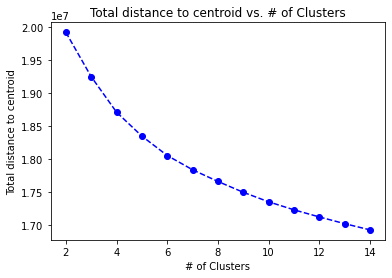

In [39]:
# Investigate the change in within-cluster distance across number of clusters
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('# of Clusters');
plt.ylabel('Total distance to centroid');
plt.title('Total distance to centroid vs. # of Clusters');

In [40]:
# Re-fit KMeans with the chosen number of clusters based on running over loop. 
kmeans = KMeans(8).fit(azdias_pca)
azdias_pred = kmeans.predict(azdias_pca)

# Repeat analysis with customer data 

In [41]:
# Use clean_data function to clean up original dataset 
customers_clean = clean_data(customers)

In [42]:
# Ensure all variables are of numerical type 
customers_clean.select_dtypes(include='object').head()

,PRODUCT_GROUP,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,MULTI_BUYER
1,COSMETIC_AND_FOOD,MULTI_BUYER
2,COSMETIC,MULTI_BUYER
3,FOOD,MULTI_BUYER
4,COSMETIC_AND_FOOD,MULTI_BUYER


In [43]:
# Investigate values in product group 
customers_clean['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    72915
FOOD                 32261
COSMETIC             29887
Name: PRODUCT_GROUP, dtype: int64

In [44]:
# Investigate values from customer group 
customers_clean['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     95171
SINGLE_BUYER    39892
Name: CUSTOMER_GROUP, dtype: int64

In [45]:
# Create dummy variables for these categories 
dummies = ['PRODUCT_GROUP', 'CUSTOMER_GROUP']
customers_clean = create_dummies(customers_clean, dummies)

In [46]:
# Replace NaNs with zeros 
customers_clean = customers_clean.replace(np.nan, 0)

In [47]:
# Drop columns 
customers_clean.drop('LNR', axis=1, inplace=True)

In [48]:
# Impute and scale the data using previous approach 
customers_imputed = pd.DataFrame(imputer.fit_transform(customers_clean), columns=customers_clean.columns)
customers_ss = pd.DataFrame(scaler.fit_transform(customers_imputed), columns=customers_imputed.columns)

In [49]:
# Re-apply PCA to the data 
customers_pca = pca.fit_transform(customers_ss)

In [50]:
# Use prediction method on PCA-applied data
customers_pred = kmeans.predict(customers_pca)

## Comparison 

In [51]:
# Obtain proportion of data in each cluster for the general population 
counts_cluster_gen = pd.Series(azdias_pred).value_counts().sort_index()
counts_cluster_gen.index = [1,2,3,4,5,6,7,8]

prop_cluster_gen = []
for value in counts_cluster_gen:
    prop = value / len(azdias_pred)
    prop_cluster_gen.append(prop)

prop_cluster_general = pd.Series(prop_cluster_gen)
prop_cluster_general.index = [1,2,3,4,5,6,7,8]

In [52]:
# Obtain proportion of data in each cluster for the customer data
counts_cluster_customers = pd.Series(customers_pred).value_counts().sort_index()
counts_cluster_customers.index = [1,2,3,4,5,6,7,8]

prop_cluster_customers = []
for value in counts_cluster_customers:
    prop = value / len(customers_pred)
    prop_cluster_customers.append(prop)

prop_cluster_customers = pd.Series(prop_cluster_customers)
prop_cluster_customers.index = [1,2,3,4,5,6,7,8]

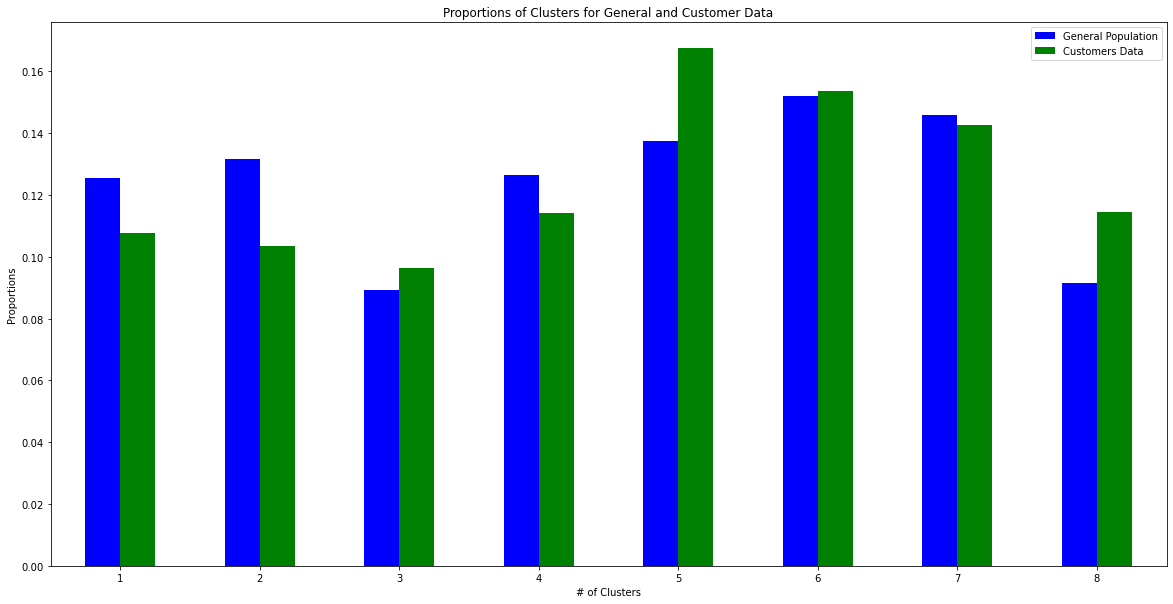

In [53]:
# Create a plot to compare the difference between population and customer datasets
prop = pd.DataFrame({'General Population': prop_cluster_general,
                     'Customers Data': prop_cluster_customers})
ax = prop.plot.bar(rot=0, figsize=(20, 10),color = ['b','g'])
plt.xlabel('# of Clusters')
plt.ylabel('Proportions')
plt.title('Proportions of Clusters for General and Customer Data');

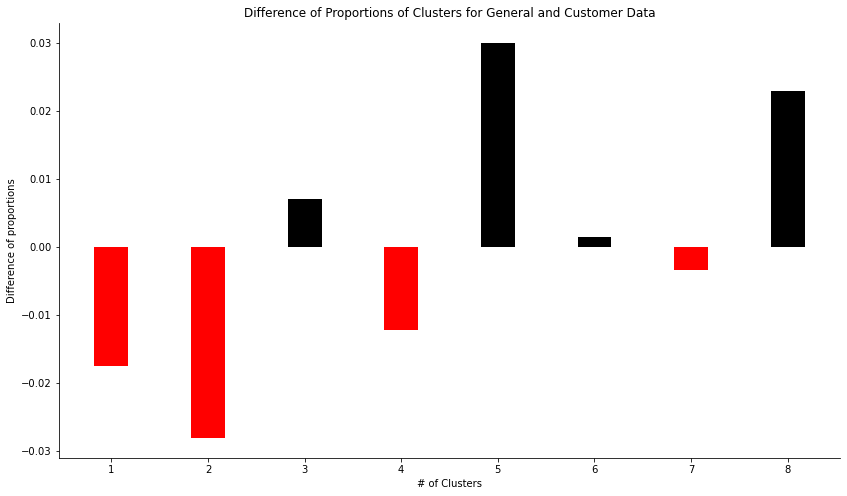

In [54]:
# Barplots of difference of Cluster proportions at the Customer and Population Datasets
prop_diff = prop_cluster_customers - prop_cluster_general
positive= prop_diff > 0


# Create plot
fig, ax = plt.subplots(figsize=(14, 8))
index = np.arange(1,9)
bar_width = 0.35 
diff = plt.bar(index, prop_diff, bar_width,
                 color=np.vectorize({True: 'k', False: 'r'}.get)(positive)
              )

plt.xlabel('# of Clusters')
plt.ylabel('Difference of proportions')
plt.title('Difference of Proportions of Clusters for General and Customer Data')
sns.despine();

Cluster 3 is the most overrepresented while cluster 6 is the most underrepresented

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [55]:
# Import training data
mailout_train = pd.read_csv('./MAILOUT_052018_TRAIN.csv',low_memory = False)

In [56]:
# Visualize training data
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [57]:
# Obtain our target variable RESPONSE
responses_count = mailout_train['RESPONSE'].value_counts(dropna=False)
responses_count

0    42430
1      532
Name: RESPONSE, dtype: int64

### Preparing the data

In [58]:
# Apply our standard cleaning routine
mailout_clean = clean_data(mailout_train)

In [59]:
# Drop NA values
responses_count = mailout_clean['RESPONSE'].value_counts(dropna=False)
responses_count

0    33765
1      424
Name: RESPONSE, dtype: int64

In [60]:
# Calculate percent of people who became customers
perc_resp = responses_count.values[1] * 100 / len(mailout_clean)
perc_resp

1.240164965339729

Only about 1.24% actually responded to the survey

In [61]:
# Checking number of nulls
mailout_clean.isnull().sum().sum()

22563

In [62]:
# Checking number of object data 
mailout_clean.select_dtypes(include='object').sum().sum()

0.0

In [63]:
# Drop LNR, the ID variable
mailout_clean.drop('LNR', axis=1, inplace=True)

In [64]:
# split data into target and feature variables
target = mailout_clean['RESPONSE']

# drop RESPONSE variable
features = mailout_clean.drop('RESPONSE', axis=1)

In [65]:
# Perform imputation and scaling using our sklearn methods, as above
imputed_mailout = pd.DataFrame(imputer.fit_transform(features.values), columns=features.columns)
scaled_mailout = pd.DataFrame(scaler.fit_transform(imputed_mailout.values), columns=imputed_mailout.columns)
features = scaled_mailout

### Modeling the data

In [66]:
# Initialize all five different models for fitting
model_A = RandomForestClassifier(random_state=2)
model_B = AdaBoostClassifier(random_state=2)
model_C = GradientBoostingClassifier(random_state=2)
model_D = RandomForestRegressor(random_state=2)
model_E = GradientBoostingRegressor(random_state=2)

In [67]:
# Prepare subsets for analysis
subsets = KFold(n_splits=5, random_state=2, shuffle = True)
subsets.get_n_splits(features, target)
print(subsets)

KFold(n_splits=5, random_state=2, shuffle=True)


In [68]:
# Run loops to evaluate each model individually 
for i, model in enumerate([model_A, model_B, model_C, model_D, model_E]):
    
    j = 0
    for train_idx, valid_idx in subsets.split(features, target):
        
        X_train, X_valid = features.iloc[train_idx], features.iloc[valid_idx]
        y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        
        score = roc_auc_score(y_valid, y_pred)
        
        j += 1

        print('Classifier {}: Fold {} Score: {}'.format(i+1, j, score))

Classifier 1: Fold 1 Score: 0.5
Classifier 1: Fold 2 Score: 0.5
Classifier 1: Fold 3 Score: 0.5
Classifier 1: Fold 4 Score: 0.5
Classifier 1: Fold 5 Score: 0.5
Classifier 2: Fold 1 Score: 0.49992587101556707
Classifier 2: Fold 2 Score: 0.49992599171107166
Classifier 2: Fold 3 Score: 0.5
Classifier 2: Fold 4 Score: 0.4999259478672986
Classifier 2: Fold 5 Score: 0.4999259588331112
Classifier 3: Fold 1 Score: 0.49992587101556707
Classifier 3: Fold 2 Score: 0.49955595026642985
Classifier 3: Fold 3 Score: 0.4997780736795384
Classifier 3: Fold 4 Score: 0.4999259478672986
Classifier 3: Fold 5 Score: 0.49985191766622245
Classifier 4: Fold 1 Score: 0.6834086579465475
Classifier 4: Fold 2 Score: 0.7648016577856719
Classifier 4: Fold 3 Score: 0.7286843046589546
Classifier 4: Fold 4 Score: 0.7583205320731841
Classifier 4: Fold 5 Score: 0.7465447455451898
Classifier 5: Fold 1 Score: 0.7516838438668229
Classifier 5: Fold 2 Score: 0.8038365174948374
Classifier 5: Fold 3 Score: 0.8029931024925041
Clas

In [69]:
# Separate the mailout_train data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target)

In [70]:
# Perform cross-validation using our best model fit 
parameters = {'n_estimators': [50, 100, 200],
              'min_samples_split': [2, 3, 4]}

gb_model = GridSearchCV(estimator=model_E, param_grid=parameters, scoring='roc_auc')
gb_model.fit(X_train, y_train)

gb_model.best_params_

{'min_samples_split': 4, 'n_estimators': 50}

In [71]:
# Fit a model using the best parameters
model = GradientBoostingRegressor(min_samples_split=4, n_estimators=50, random_state=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

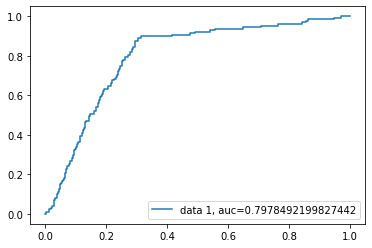

0.7978492199827442


In [72]:
# Plot the results 
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(auc)

This curve shows good separation between the different classes. Higher AUC values (typically near 1) indicate that the model performs well at classifying between the different groups. Conversely, a value closer to 0.5 signifies that classification is not effective. The AUC score is plotted along with TPR (True Positive Rate) and FPR (False Positive Rate) on the y and x axes, respectively. 
The curve produces higher values of TPR than FPR everywhere and an AUC of 0.7978 which indicates good classification of the data. Possible improvements could aim at increasing the number of parameters used in the GridSearchCV step and an increase in the number of models being evaluated.